In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import numpy as np
import math
import sys
import os
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
from plyfile import *
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d 
import numpy as np
import scipy.stats
import random
import pandas as pd
from sklearn.metrics import confusion_matrix

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#点云文件导入
##############导入点云数据#################
pcd_AC13_1 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC13-1.ply")
pcd_AC13_2 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC13-2.ply")
pcd_AC16_3 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC16-3.ply")
pcd_AC16_4 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC16-4.ply")
pcd_UT5_1  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-1.ply")
pcd_UT5_2  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-2.ply")
pcd_UT5_3  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-3.ply")
pcd_UT5_4  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-4.ply")
pcd_SMA13_1= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/SMA13-1.ply")
pcd_SMA13_2= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/SMA13-2.ply")
pcd_OGFC10_1= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/OGFC10-1.ply")
#############点云标准化####################
def standard_pointcloud(point_cloud):
    Point_standard=[]
    Point=np.asarray(point_cloud.points)    
    x=np.array(Point[:,0])[...,np.newaxis]
    y=np.array(Point[:,1])[...,np.newaxis]
    z=np.array(Point[:,2])[...,np.newaxis]
    Point_standard=np.concatenate((x-np.min(x),y-np.min(y),z-np.min(z)),axis=-1)
    return Point_standard

AC13_1=standard_pointcloud(pcd_AC13_1)
AC13_2=standard_pointcloud(pcd_AC13_2)
AC16_3=standard_pointcloud(pcd_AC16_3)
AC16_4=standard_pointcloud(pcd_AC16_4)
UT5_1=standard_pointcloud(pcd_UT5_1)
UT5_2=standard_pointcloud(pcd_UT5_2)
UT5_3=standard_pointcloud(pcd_UT5_3)
UT5_4=standard_pointcloud(pcd_UT5_4)
SMA13_1= standard_pointcloud(pcd_SMA13_1)
SMA13_2= standard_pointcloud(pcd_SMA13_2)
OGFC10_1 =  standard_pointcloud(pcd_OGFC10_1)

point_cloud_array_group = []
point_cloud_array_group.append(AC13_1)
point_cloud_array_group.append(AC13_2)
point_cloud_array_group.append(AC16_3)
point_cloud_array_group.append(AC16_4)
point_cloud_array_group.append(UT5_1)
point_cloud_array_group.append(UT5_2)
point_cloud_array_group.append(UT5_3)
point_cloud_array_group.append(UT5_4)
point_cloud_array_group.append(SMA13_1)
point_cloud_array_group.append(SMA13_2)
point_cloud_array_group.append(OGFC10_1)
#############点云标准化####################
def standard_pointcloud(point_cloud):
    Point_standard=[]  
    x=np.array(point_cloud[:,0])[...,np.newaxis]
    y=np.array(point_cloud[:,1])[...,np.newaxis]
    z=np.array(point_cloud[:,2])[...,np.newaxis]
    Point_standard=np.concatenate((x-np.min(x),y-np.min(y),z-np.min(z)),axis=-1)
    return Point_standard
######################按照计算的H_final进行窗口滑动切分#########################
H_final=51
AC13=[0,6,4,3.5,5.5,7.5,10.5,16,23.5,18.5,5,0]#级配
AC16=[0,5.4,2.4,2.4,3.7,4.1,7.8,5.5,26.3,20.1,16.6,5.7]#级配 
SMA13=[0,10.7,2.1,1.4,1.1,1.2,2.9,9.4,30.3,31.5,8.2,1.2]#级配
UT5=[0,6.7,2,2.5,5,20,13.4,48.8,1.5,0.1,0,0]#级配
OGFC10=[0,4,1.5,2,2,2.5,4,44,35,5,0,0]#级配
def split_slide(point_cloud_array_origion,H_new=H_final, intervial =[5,5]):
    L=int(np.max(point_cloud_array_origion[:,0]))
    W=int(np.max(point_cloud_array_origion[:,1]))
    Point_cloud_small = []
    L_intervial = intervial[0]
    W_intervial = intervial[1]
    for i in range (0,L-H_new,L_intervial):
        for j in range (0,W-H_new,W_intervial):
            temp_point_cloud = point_cloud_array_origion[np.where((point_cloud_array_origion[:,1]>i)&
                                                                  (point_cloud_array_origion[:,1]<(H_new+i))&
                                                                  (point_cloud_array_origion[:,0]>j)&
                                                                  (point_cloud_array_origion[:,0]<(H_new+j)))]
            temp_point_cloud = standard_pointcloud(temp_point_cloud)
            Point_cloud_small.append(temp_point_cloud)
    return Point_cloud_small
####################原始图像拆分子点云集########################################
PointCloud_new =[]
#制作Ground truth
Y_Data=np.zeros((1,12))
for i in range(11):
    temp=split_slide(point_cloud_array_group[i])
    #print(len(temp))
    PointCloud_new=np.concatenate((PointCloud_new,temp),axis=0)
    if (i==0) or (i==1):
        temp2 = np.full((len(temp),12),AC13)
    elif (i==2) or (i==3):
        temp2 = np.full((len(temp),12),AC16)
    elif (i==4) or (i==5) or (i==6) or (i==7):
        temp2 = np.full((len(temp),12),UT5)
    elif (i==8) or (i==9):
        temp2 = np.full((len(temp),12),SMA13)
    elif (i==10):
        temp2 = np.full((len(temp),12),OGFC10) 
    #print(temp2.shape)
    Y_Data = np.concatenate((Y_Data,temp2),axis=0)
    #print(np.array(Y_Data).shape)
Y_Data = np.delete(Y_Data, 1, 0)#把第一行0删掉
print(Y_Data.shape)
#print(len(PointCloud_new))
#计算最小子点云点数
num_min=PointCloud_new[0].shape[0]
for i in range(len(PointCloud_new)):
    num_point = PointCloud_new[i].shape[0]
    if num_min>num_point:
        num_min = num_point
#print(num_min)
#根据最小点云数进行降采样，根据设置的点数降采样
def pointCloud_downsampling(Point_cloud_array, num_pointCloud=30000):
    # estimate radius for rolling ball
    pcd=o3d.geometry.PointCloud()
    pcd.points=o3d.utility.Vector3dVector(Point_cloud_array)
    pcd.estimate_normals()
    # estimate radius for rolling ball
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 1.5 * avg_dist   
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))
    pcd_new = o3d.geometry.TriangleMesh.sample_points_uniformly(mesh, number_of_points=num_pointCloud) # 采样点云
    #o3d.visualization.draw_geometries([pcd_new],width=1024, height=1024)
    New_Point_cloud_array = np.asarray(pcd_new.points)
    return New_Point_cloud_array

PointCloud_Standard =[]
for i in range(len(PointCloud_new)):
    PointCloud_Standard.append(pointCloud_downsampling(PointCloud_new[i],3000))
print(np.array(PointCloud_Standard).shape)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(1579, 12)
(1579, 3000, 3)


In [3]:
#### 数据集1579分，切分为1379训练 200测试#######################
arr = np.array(range(0, 1579, 1))
r = np.random.permutation(arr)
Train_X_Data = []
Train_Y_Data = []
for i in range(1379):
    Train_X_Data.append(PointCloud_Standard[r[i]])
    Train_Y_Data.append(Y_Data[r[i]])

Test_X_Data = []
Test_Y_Data = []
for i in range(1379,1579):
    Test_X_Data.append(PointCloud_Standard[r[i]])
    Test_Y_Data.append(Y_Data[r[i]])
    
Train_X_Data = np.array(Train_X_Data)
Train_Y_Data = np.array(Train_Y_Data)
Test_X_Data = np.array(Test_X_Data)
Test_Y_Data = np.array(Test_Y_Data)

print(Train_X_Data.shape)
print(Train_Y_Data.shape)
print(Test_X_Data.shape)
print(Test_Y_Data.shape)


(1379, 3000, 3)
(1379, 12)
(200, 3000, 3)
(200, 12)


In [4]:
class CustomConvolution(keras.layers.Layer):
    def __init__(self, filters=64, kernel_size=(1, 1), strides=(1, 1), padding='VALID', bn_momentum=0.99,
                 activation=None, apply_bn=False):
        super(CustomConvolution, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.bn_momentum = bn_momentum
        self.activation = activation
        self.convolution = keras.layers.Conv2D(filters, kernel_size, strides, padding)
        self.apply_bn = apply_bn
        if self.apply_bn:
            self.bn = keras.layers.BatchNormalization(momentum=bn_momentum)

    def call(self, inputs, training=None):
        x = self.convolution(inputs)
        if self.apply_bn:
            x = self.bn(x, training=training)
        if self.activation:
            x = self.activation(x)
        return x

    def get_config(self):
        config = super(CustomConvolution, self).get_config()
        config.update(
            {
                'filters': self.filters,
                'kernel_size': self.kernel_size,
                'strides': self.strides,
                'padding': self.padding,
                'bn_momentum': self.bn_momentum,
                'activation': self.activation,
                'apply_bn': self.apply_bn
            }
        )
    @classmethod
    def from_config(cls, config):
        return cls(**config)

class CustomDense(keras.layers.Layer):
    def __init__(self, units=256, activation=tf.nn.relu, bn_momentum=0.99, apply_bn=False):
        super(CustomDense, self).__init__()
        self.filters = units
        self.bn_momentum = bn_momentum
        self.activation = activation
        self.dense = keras.layers.Dense(units)
        self.apply_bn = apply_bn
        if self.apply_bn:
            self.bn = keras.layers.BatchNormalization(momentum=bn_momentum)

    def call(self, inputs, training=None):
        x = self.dense(inputs)
        if self.apply_bn:
            x = self.bn(x, training=training)
        if self.activation:
            x = self.activation(x)
        return x

    def get_config(self):
        config = super(CustomDense, self).get_config()
        config.update(
            {
                'units': self.units,
                'activation': self.activation,
                'bn_momentum': self.bn_momentum,
                'apply_bn': self.apply_bn
            }
        )

    @classmethod
    def from_config(cls, config):
        return cls(**config)

class input_TransformNet(keras.layers.Layer):
    def __init__(self, add_regularization=False, bn_momentum=0.99, name=None, **kwargs):
        super(input_TransformNet, self).__init__(name=name, **kwargs)
        self.add_regularization = add_regularization
        self.bn_momentum = bn_momentum
        self.conv0 = CustomConvolution(filters=64, kernel_size=(1, 3), strides=(1, 1), padding='VALID',
                                       bn_momentum=bn_momentum, activation=tf.nn.relu,apply_bn=True)
        self.conv1 = CustomConvolution(filters=128, kernel_size=(1, 1), strides=(1, 1), padding='VALID',
                                       bn_momentum=self.bn_momentum,apply_bn=True)
        self.conv2 = CustomConvolution(filters=1024, kernel_size=(1, 1), strides=(1, 1), padding='VALID',
                                       bn_momentum=self.bn_momentum,apply_bn=True)
        self.dense0 = CustomDense(units=512, activation=tf.nn.relu, bn_momentum=self.bn_momentum,apply_bn=True)
        self.dense1 = CustomDense(units=256, activation=tf.nn.relu, bn_momentum=self.bn_momentum,apply_bn=True)

    def build(self, input_shape):
        self.K = input_shape[2]
        self.w = self.add_weight(name='w', shape=[256, self.K ** 2], initializer=tf.zeros_initializer, dtype=tf.float32)
        self.b = self.add_weight(name='b', shape=(self.K, self.K), initializer=tf.zeros_initializer, dtype=tf.float32)
        I = tf.constant(np.eye(self.K), dtype=tf.float32)
        self.b = tf.math.add(self.b, I)

    def call(self, inputs, training=None):
        x = inputs  # BxNx3
        x = tf.expand_dims(x, axis=-1)  # BxNx3x1
        x = self.conv0(x, training=training)  # BxNx1x64
        x = self.conv1(x, training=training)  # BxNx1x128
        x = self.conv2(x, training=training)  # BxNx1x1024
        x = tf.squeeze(x, axis=2)  # BxNx1024
        x = tf.reduce_max(x, axis=1)  # Bx1024sss
        x = self.dense0(x, training=training)  # Bx512
        x = self.dense1(x, training=training)  # Bx256

        x = tf.expand_dims(x, axis=1)  # Bx1x256
        x = tf.matmul(x, self.w)  # Bx1xK**2
        x = tf.squeeze(x, axis=1)  # BxK**2
        x = tf.reshape(x, (-1, self.K, self.K))  # BxKxK
        x += self.b

        if self.add_regularization:
            eye = tf.constant(np.eye(self.K), dtype=tf.float32)
            x_transpose = tf.transpose(x, perm=[0, 2, 1])
            x_xt = tf.matmul(x, x_transpose)
            reg = tf.nn.l2_loss(eye - x_xt)
            self.add_loss(1e-3 * reg)

        return tf.matmul(inputs, x)

    def get_config(self):
        config = super(TransformNet, self).get_config()
        config.update(
            {
                'add_regularization': self.add_regularization,
                'bn_momentum': self.bn_momentum,
            }
        )

    @classmethod
    def from_config(cls, config):
        return cls(**config)

class feature_TransformNet(keras.layers.Layer):
    def __init__(self, add_regularization=False, bn_momentum=0.99, name=None, **kwargs):
        super(feature_TransformNet, self).__init__(name=name, **kwargs)
        self.add_regularization = add_regularization
        self.bn_momentum = bn_momentum
        self.conv0 = CustomConvolution(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='VALID',
                                       bn_momentum=bn_momentum, activation=tf.nn.relu,apply_bn=True)
        self.conv1 = CustomConvolution(filters=128, kernel_size=(1, 1), strides=(1, 1), padding='VALID',
                                       bn_momentum=self.bn_momentum,apply_bn=True)
        self.conv2 = CustomConvolution(filters=1024, kernel_size=(1, 1), strides=(1, 1), padding='VALID',
                                       bn_momentum=self.bn_momentum,apply_bn=True)
        self.dense0 = CustomDense(units=512, activation=tf.nn.relu, bn_momentum=self.bn_momentum,apply_bn=True)
        self.dense1 = CustomDense(units=256, activation=tf.nn.relu, bn_momentum=self.bn_momentum,apply_bn=True)

    def build(self, input_shape):
        self.K = input_shape[-1]
        self.w = self.add_weight(name='w', shape=[256, self.K ** 2], initializer=tf.zeros_initializer, dtype=tf.float32)
        self.b = self.add_weight(name='b', shape=(self.K, self.K), initializer=tf.zeros_initializer, dtype=tf.float32)
        I = tf.constant(np.eye(self.K), dtype=tf.float32)
        self.b = tf.math.add(self.b, I)

    def call(self, inputs, training=None):
        x = inputs  # BxNx1x64
        x = self.conv0(x, training=training)  # BxNx1x64
        x = self.conv1(x, training=training)  # BxNx1x128
        x = self.conv2(x, training=training)  # BxNx1x1024
        x = tf.squeeze(x, axis=2)  # BxNx1024
        x = tf.reduce_max(x, axis=1)  # Bx1024sss
        x = self.dense0(x, training=training)  # Bx512
        x = self.dense1(x, training=training)  # Bx256

        x = tf.expand_dims(x, axis=1)  # Bx1x256
        x = tf.matmul(x, self.w)  # Bx1xK**2
        x = tf.squeeze(x, axis=1)  # BxK**2
        x = tf.reshape(x, (-1, self.K, self.K))  # BxKxK
        x += self.b

        if self.add_regularization:
            eye = tf.constant(np.eye(self.K), dtype=tf.float32)
            x_transpose = tf.transpose(x, perm=[0, 2, 1])
            x_xt = tf.matmul(x, x_transpose)
            reg = tf.nn.l2_loss(eye - x_xt)
            self.add_loss(1e-3 * reg)

        return tf.matmul(tf.squeeze(inputs, axis=2), x) #BxNxK 把第3轴去掉保持维度统一

    def get_config(self):
        config = super(TransformNet, self).get_config()
        config.update(
            {
                'add_regularization': self.add_regularization,
                'bn_momentum': self.bn_momentum,
            }
        )

    @classmethod
    def from_config(cls, config):
        return cls(**config)

def get_model(n_classes, bn_momentum=0.99):
    add_regularization = True
    # Initialize the input layer
    input_layer = keras.Input(shape=(None, 3),
                              name='input_points')  # MxNx3 where M is batch size,N is number of points and 3 for channels
    # Input transform layer
    input_transform = input_TransformNet(add_regularization=add_regularization, bn_momentum=bn_momentum,
                                   name='input_transformation')(input_layer)  # BxNx3 --> BxNx3
    input_transform = tf.expand_dims(input_transform, axis=-1)  # BxNx3 --> BxNx3x1

    shared_layer_1 = CustomConvolution(filters=64, kernel_size=(1, 3), strides=(1, 1), padding='VALID',
                                       bn_momentum=bn_momentum, activation=tf.nn.relu,apply_bn=True)(input_transform)  # BxNx3x1 --> BxNx1x64
    shared_layer_2 = CustomConvolution(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='VALID',
                                       bn_momentum=bn_momentum, activation=tf.nn.relu,apply_bn=True)(shared_layer_1)  # BxNx1x64 --> BxNx1x64
    #shared_layer_2 = tf.squeeze(shared_layer_2, axis=2) # BxNx1x64 --> BxNx64

    feature_transform = feature_TransformNet(add_regularization=add_regularization, bn_momentum=bn_momentum,
                                             name='feature_transformation')(shared_layer_2)  # BxNx1x64--> BxNx64
    feature_transform = tf.expand_dims(feature_transform, axis=2)  # BxNx64 --> BxNx1x64

    shared_layer_3 = CustomConvolution(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='VALID',
                                       bn_momentum=bn_momentum, activation=tf.nn.relu,apply_bn=True)(feature_transform)  # BxNx1x64 --> BxNx1x64
    shared_layer_4 = CustomConvolution(filters=128, kernel_size=(1, 1), strides=(1, 1), padding='VALID',
                                       bn_momentum=bn_momentum, activation=tf.nn.relu,apply_bn=True)(shared_layer_3)  # BxNx1x64 --> BxNx1x128
    shared_layer_5 = CustomConvolution(filters=1024, kernel_size=(1, 1), strides=(1, 1), padding='VALID',
                                       bn_momentum=bn_momentum, activation=tf.nn.relu,apply_bn=True)(shared_layer_4)  # BxNx1x128 --> BxNx1x1024

    shared_layer_5 = tf.squeeze(shared_layer_5, axis=2)  # BxNx1x1024 --> BxNx1024

    global_features = tf.reduce_max(shared_layer_5, axis=1)  # BxNx1024 --> Bx1024

    dense0 = CustomDense(units=512, activation=tf.nn.relu, bn_momentum=bn_momentum,apply_bn=True)(global_features)
    #dense0 = keras.layers.Dropout(0.5)(dense0)
    dense1 = CustomDense(units=256, activation=tf.nn.relu, bn_momentum=bn_momentum,apply_bn=True)(dense0)
    #dense1 = keras.layers.Dropout(0.5)(dense1)
    dense1 = keras.layers.Flatten()(dense1)

    output_layer = keras.layers.Dense(units=n_classes, activation=tf.nn.relu)(dense1)#级配每档的分计筛余比例

    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model

In [5]:
################网络训练###########################
n_classes = 12
PointNet= get_model(n_classes)
PointNet.summary()
logdir = "./data/log"
lr = 1e-3
#PointNet.load_weights("PointNet.h5")
PointNet.compile(optimizer=keras.optimizers.Adam(lr), 
                 loss=tf.keras.losses.MAE)
Callback = keras.callbacks.ModelCheckpoint("PointNet-3000点版本.h5", 
                                           monitor='val_loss', 
                                           save_best_only=True, 
                                           save_weights_only=True)
Model_history=PointNet.fit(x=Train_X_Data,y=Train_Y_Data,batch_size=16,epochs = 200,validation_split=0.2,callbacks=Callback)
#PointNet.save_weights("PointNet.h5")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_points (InputLayer)    [(None, None, 3)]         0         
_________________________________________________________________
input_transformation (input_ (None, None, 3)           807040    
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, None, 3, 1)        0         
_________________________________________________________________
custom_convolution_3 (Custom (None, None, 1, 64)       512       
_________________________________________________________________
custom_convolution_4 (Custom (None, None, 1, 64)       4416      
_________________________________________________________________
feature_transformation (feat (None, None, 64)          1857216   
_________________________________________________________________
tf.expand_dims_1 (TFOpLambda (None, None, 1, 64)       0     

69/69 [==============================] - 4s 55ms/step - loss: 1.3662 - val_loss: 3.4858
Epoch 107/200
69/69 [==============================] - 4s 55ms/step - loss: 1.2859 - val_loss: 2.1412 ETA: - ETA
Epoch 108/200
69/69 [==============================] - 4s 55ms/step - loss: 0.7842 - val_loss: 0.8249 ETA: 2s - - ETA: 1s - - ETA: 0s 
Epoch 109/200
69/69 [==============================] - 4s 55ms/step - loss: 0.7573 - val_loss: 1.8842s - loss - E - ETA: 0s - loss: 0.751
Epoch 110/200
69/69 [==============================] - 4s 55ms/step - loss: 0.8622 - val_loss: 1.9757
Epoch 111/200
69/69 [==============================] - 4s 55ms/step - loss: 1.0752 - val_loss: 1.0838
Epoch 112/200
69/69 [==============================] - 4s 55ms/step - loss: 0.9316 - val_loss: 1.8943
Epoch 113/200
69/69 [==============================] - 4s 55ms/step - loss: 1.5140 - val_loss: 4.9537
Epoch 114/200
69/69 [==============================] - 4s 55ms/step - loss: 1.2476 - val_loss: 3.6495 ETA: 1s - loss: 

In [6]:
Save_history = Model_history.history
Save_history = pd.DataFrame(Save_history)
writer = pd.ExcelWriter('C:/Users/Administrator/Desktop/surface/实验结果存放/PointNet-3000点版本_loss.xlsx')  #关键2，创建名称为hhh的excel表格
Save_history.to_excel(writer,'page_1',float_format='%.5f')  #关键3，float_format 控制精度，将data_df写到hhh表格的第一页中。若多个文件，可以在page_2中写入
writer.save()  

7/7 [==============================] - 3s 33ms/step - loss: 0.7787


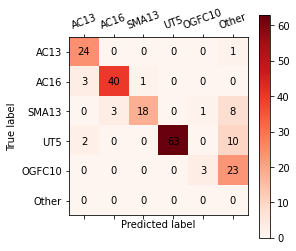

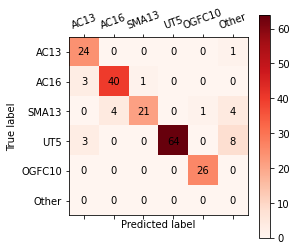

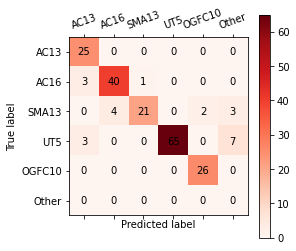

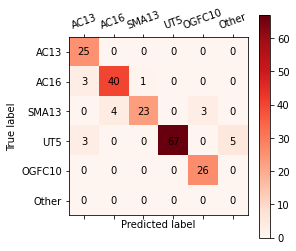

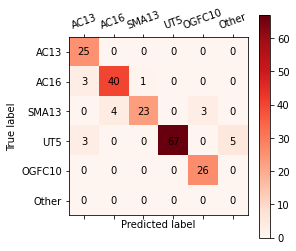

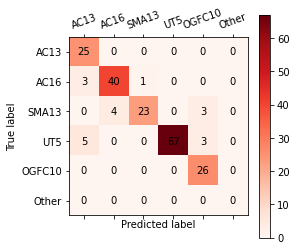

In [6]:
############Test性能测试###################
def identification(predicted_gradient,real_gradient,threshold):
    AC13=[0,6,4,3.5,5.5,7.5,10.5,16,23.5,18.5,5,0]#级配
    AC16=[0,5.4,2.4,2.4,3.7,4.1,7.8,5.5,26.3,20.1,16.6,5.7]#级配 
    SMA13=[0,10.7,2.1,1.4,1.1,1.2,2.9,9.4,30.3,31.5,8.2,1.2]#级配
    UT5=[0,6.7,2,2.5,5,20,13.4,48.8,1.5,0.1,0,0]#级配
    OGFC10=[0,4,1.5,2,2,2.5,4,44,35,5,0,0]#级配
    if np.average(np.abs(real_gradient-AC13))==0:
        Real_result=0
    elif np.average(np.abs(real_gradient-AC16))==0:
        Real_result=1
    elif np.average(np.abs(real_gradient-SMA13))==0:
        Real_result=2
    elif np.average(np.abs(real_gradient-UT5))==0:
        Real_result=3
    elif np.average(np.abs(real_gradient-OGFC10))==0:
        Real_result=4
        
    R_AC13=np.average(np.abs(predicted_gradient-AC13))
    R_AC16=np.average(np.abs(predicted_gradient-AC16))
    R_SMA13=np.average(np.abs(predicted_gradient-SMA13))
    R_UT5=np.average(np.abs(predicted_gradient-UT5))
    R_OGFC10=np.average(np.abs(predicted_gradient-OGFC10))
    
    Predicted_result =np.argmin(np.array([R_AC13,R_AC16,R_SMA13,R_UT5,R_OGFC10]))
    
    if np.min(np.array([R_AC13,R_AC16,R_SMA13,R_UT5,R_OGFC10]))>threshold:
        Predicted_result = 5
    
    return Real_result, Predicted_result

n_classes = 12
PointNet= get_model(n_classes)
PointNet.load_weights("PointNet-3000点版本.h5")
PointNet.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss=tf.keras.losses.MAE)
PointNet.evaluate(Test_X_Data,Test_Y_Data)
Thr_list = [0.5,1,1.5,2,2.5,3]
for Thr in Thr_list:
    Real_result = []
    Predicted_result = []
    for i in range(len(Test_X_Data)):
        R,P=identification(PointNet(np.array(Test_X_Data[i])[np.newaxis,...])[0],Test_Y_Data[i],Thr)
        Real_result.append(R)
        Predicted_result.append(P)
    #######绘制混淆矩阵################
    C = confusion_matrix(Real_result, Predicted_result, labels=[0,1,2,3,4,5]) 
    plt.matshow(C, cmap=plt.cm.Reds) # 根据最下面的图按自己需求更改颜色
    plt.colorbar()
    for i in range(len(C)):
        for j in range(len(C)):
            plt.annotate(C[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(range(0,6), labels=['AC13','AC16','SMA13','UT5','OGFC10','Other'], rotation=20) # 将x轴或y轴坐标，刻度 替换为文字/字符
    plt.yticks(range(0,6), labels=['AC13','AC16','SMA13','UT5','OGFC10','Other'])
    plt.savefig('C:/Users/Administrator/Desktop/surface/实验结果存放/PointNet-3000点版本'+ str(Thr) + '.png',dpi=600)#保存图片
    plt.show()